In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
import pickle as pickle

%matplotlib inline

In [2]:
with open('./data/220k_cleaned.p','rb') as f:
    p = pickle.load(f)
df_cleaned = pd.read_pickle('./data/cleaned_data.pkl')
len(p)

KeyboardInterrupt: 

In [ ]:
# anormal = []
# for key in p:
#     if p[key]['news']['publish_timestamp_ms'] > p[key]['tweets'][0]['timestamp_ms']:
#         anormal.append(key)
# len(anormal)

# 1. prepare time_series data

In [3]:
MAX_SPAN =  24 # in hours
INTERVAL = 0.25 # in hours
GATHER_POINT = 10 # in hours

In [4]:
df = pd.DataFrame({'url':list(p.keys())})

In [5]:
# calculate time difference and save it in original dict
# time_zone: start time of the zone
for k in p:
    tweet_list = p[k]['tweets']
    news_time = p[k]['tweets'][0]['timestamp_ms']
    for i in tweet_list:
        time_diff = (i['timestamp_ms'] - news_time)/60/60/1000
        i['time_diff'] = time_diff
        i['time_zone'] = i['time_diff'] / INTERVAL // 1 * INTERVAL # according to interval

In [6]:
def tweet_text(url, zone):
    text_list = []
    for i in p[url]['tweets']:
        time_zone = i['time_zone']
        if time_zone == zone:
            text = i['text']
            words = text.split(' ')
            sent = ' '.join([j for j in words if '@' not in j and 'http' not in j])
            text_list.append(sent)
    return text_list

In [7]:
for i in np.linspace(0, MAX_SPAN, MAX_SPAN/INTERVAL+1):
    df['tweet_text_'+str(i)+'h'] = df['url'].apply(lambda x: tweet_text(x, i))
    
df['tweet_amount_0.0h'] = 0
for i in np.linspace(INTERVAL, MAX_SPAN, MAX_SPAN/INTERVAL):
    df['tweet_amount_'+str(i)+'h'] = df.apply(lambda x: len(x['tweet_text_'+str(i-INTERVAL)+'h'])+x['tweet_amount_'+str(i-INTERVAL)+'h'], axis = 1)

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


In [8]:
df_ts = df.copy()
for i in np.linspace(0, MAX_SPAN, MAX_SPAN/INTERVAL+1):
    df_ts.drop(columns=['tweet_text_'+str(i)+'h'], inplace = True)

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [ ]:
df_ts.to_pickle('./data/time_series.p')

In [9]:
# gather certain length of data
column_index = list(range(0, int(GATHER_POINT / INTERVAL)+2))
column_index.append(df_ts.shape[1]-1)
data_ts = df_ts.iloc[:, column_index]
data_ts = data_ts.rename(columns={'tweet_amount_24.0h': 'label'})
data_ts.head(2)

,url,tweet_amount_0.0h,tweet_amount_0.25h,tweet_amount_0.5h,tweet_amount_0.75h,tweet_amount_1.0h,tweet_amount_1.25h,tweet_amount_1.5h,tweet_amount_1.75h,tweet_amount_2.0h,...,tweet_amount_8.0h,tweet_amount_8.25h,tweet_amount_8.5h,tweet_amount_8.75h,tweet_amount_9.0h,tweet_amount_9.25h,tweet_amount_9.5h,tweet_amount_9.75h,tweet_amount_10.0h,label
0,https://cointelegraph.com/news/set-phasers-to-...,0,3,3,3,3,4,4,4,4,...,5,6,7,7,7,7,7,7,7,7
1,https://99bitcoins.com/bitcoin-news-summary-ju...,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


# 2. prepare event_series(text) data

In [ ]:
df_es = df_cleaned[['url','sentences','news_title']]

In [ ]:
import string
punctuation = set(string.punctuation)
from string import ascii_letters, digits

def ExtractAlphanumeric(InputString):
    return "".join([ch for ch in InputString if ch in (ascii_letters + digits+''.join(punctuation)+' '+'\n')])

def extract_twtext(url):
    tw_text = []
    tw_text = [i['text'] for i in p[url]['tweets'] if i['time_diff'] < MAX_SPAN]
    tw_clean = [' '.join([j for j in ExtractAlphanumeric(text).split(' ') if '@' not in j and 'http' not in j]) for text in tw_text]
    return tw_clean

def extract_twtime(url):
    tw_time = []
    tw_time = [round(i['time_diff'],2) for i in p[url]['tweets'] if i['time_diff'] < MAX_SPAN]
    return tw_time

In [ ]:
df_es['tw_text'] = df_es['url'].apply(lambda x: extract_twtext(x))
df_es['tw_len'] = df_es['tw_text'].apply(lambda x: len(x))
df_es['tw_time'] = df_es['url'].apply(lambda x: extract_twtime(x))

In [ ]:
df_es.to_pickle('./data/event_series.p')

In [ ]:
df_es.head(2)

In [ ]:
# gather certain length of data
df_es['time_list'] = df_es['tw_time'].apply(lambda x: [i for i in x if i < GATHER_POINT])
df_es['tw_list'] = df_es.apply(lambda x: x['tw_text'][:len(x['time_list'])], axis = 1)
df_es['num_tw'] = df_es['tw_list'].apply(lambda x: len(x))

# 3. merge and filter

In [ ]:
df_all = pd.merge(data_ts,df_es,on='url')
print('length of time series data: ', len(data_ts))
print('length of event series data: ', len(df_es))
print('length of merged data: ', len(df_all))

In [ ]:
df_all = df_all[df_all['num_tw']>1]
df_all = df_all.reset_index(drop=True)
df_all.drop(columns=['tw_text','tw_len','tw_time'], inplace = True)
len(df_all)

In [ ]:
df_all.head(2)

# 4. check bad points, save dataframe

In [ ]:
for i in list(df_all['time_list']):
    for j in i:
        if j > 24 or j < 0:
            print('!')

In [ ]:
df_all.to_pickle('./data/5h_basic.p')

# 5. prepare data for point processing

In [7]:
df_all = pd.read_pickle('./data/5h_basic.p')

In [8]:
len(df_all)

18910

In [9]:
df_all.head()

,url,tweet_amount_0.0h,tweet_amount_0.25h,tweet_amount_0.5h,tweet_amount_0.75h,tweet_amount_1.0h,tweet_amount_1.25h,tweet_amount_1.5h,tweet_amount_1.75h,tweet_amount_2.0h,...,tweet_amount_4.0h,tweet_amount_4.25h,tweet_amount_4.5h,tweet_amount_4.75h,tweet_amount_5.0h,label,sentences,news_title,time_list,tw_list
0,https://cointelegraph.com/news/set-phasers-to-...,0,3,3,3,3,4,4,4,4,...,4,4,5,5,5,7,[William Shatners positive Tweet posted yester...,Set Phasers to HODL: Star Trek's William Shatn...,"[0.0, 0.04, 0.05, 1.09, 4.36]",[Set Phasers to HODL: Star Trek's William Shat...
1,https://ohiobitcoin.com/malicious-cryptocurren...,0,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,[Malicious Cryptocurrency Mining Malware Masks...,Malicious Cryptocurrency Mining Malware Masks ...,"[0.0, 0.03]",[Malicious Cryptocurrency Mining Malware Masks...
2,https://cryptodaily.co.uk/2018/11/bitcoin-is-m...,0,1,1,4,4,4,4,4,4,...,6,6,6,6,6,7,[The office for the Manhattan District Attorne...,Bitcoin Is Making People Crazy,"[0.0, 0.57, 0.66, 0.71, 3.27, 3.28]","[Bitcoin Is Making People Crazy, #Bitcoin Is M..."
3,https://bitcoinnews.com/asia-and-australia-cry...,0,4,4,4,4,4,4,4,4,...,4,4,4,4,4,6,[Welcome to another weekly blockchain news rou...,Asia and Australia: Crypto and Blockchain News...,"[0.0, 0.0, 0.01, 0.14]",[Asia and Australia: Crypto and Blockchain New...
4,https://www.coindesk.com/waves-crypto-exchange...,0,2,2,2,2,3,3,3,3,...,3,3,3,3,3,3,[When a decentralized cryptocurrency exchange ...,Waves' Decentralized Exchange Had a $6 Million...,"[0.0, 0.06, 1.11]",[ \nDecentralized exchanges might still be a f...


In [ ]:
sent = list(df_all['sentences'])
output = open('./data/news_text.pkl', 'wb')
pickle.dump(sent, output)
output.close()

In [ ]:
tweet = list(df_all['tw_list'])
output = open('./data/tw_text.pkl', 'wb')
pickle.dump(tweet, output)
output.close()

In [ ]:
with open('./data/tw_vector.pkl','rb') as f:
    tw_vector = pickle.load(f)

In [ ]:
df_all.drop(columns=['sentences','news_title','tw_list'], inplace = True)
df_all = df_all.reset_index(drop=True)

In [ ]:
df_all['tw_vector'] = pd.Series(tw_vector)

In [ ]:
df_all.head(2)

In [ ]:
def split_data(dataframe,train_p,valid_p,test_p):
    assert train_p + valid_p + test_p == 1
    l = [i for i in range(len(dataframe))]
    random.shuffle(l)
    train_index = l[:int(train_p*len(dataframe))]
    valid_index = l[int(train_p*len(dataframe)):int((train_p+valid_p)*len(dataframe))]
    test_index = l[int((train_p+valid_p)*len(dataframe)):]
    train_df = dataframe.iloc[train_index,:].reset_index(drop=True)
    valid_df = dataframe.iloc[valid_index,:].reset_index(drop=True)
    test_df = dataframe.iloc[test_index,:].reset_index(drop=True)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(df_all, 0.9, 0, 0.1)

In [ ]:
train_df.to_pickle('./data/train.p')
test_df.to_pickle('./data/test.p')

In [11]:
train_df = pd.read_pickle('./data/train.p')
test_df = pd.read_pickle('./data/test.p')

# split test set

In [ ]:
test_df = pd.read_pickle('./data/test.p')

In [ ]:
test_h = test_df[test_df['label']>=7]
test_m = test_df[test_df['label']>=3]
test_m = test_m[test_m['label']<7]
test_l = test_df[test_df['label']<3]

In [ ]:
test_h.to_pickle('./data/test_h.p')
test_m.to_pickle('./data/test_m.p')
test_l.to_pickle('./data/test_l.p')

In [ ]:
len(test_l)

# Attach news data

In [66]:
with open('./data/news_vector.pkl','rb') as f:
    news_vector = pickle.load(f)

In [47]:
# active and popular publishers
publisher = []
with open('./util/active_websites.txt') as f:
    for i in f:
        if len(i)>2:
            publisher.append(i.strip())
            
insti_expert = []
with open('./util/top_institutions.txt') as f:
    for i in f:
        if len(i)>2:
            insti_expert.append(i.strip())
            
with open('./util/top_experts.txt') as f:
    for i in f:
        if len(i)>2:
            insti_expert.append(i.strip())

In [67]:
df_all['news_vector'] = news_vector
train_news = train_df[['url','label']].merge(df_all[['url','news_vector']], on='url', how='left')
train_news = train_news.merge(df_cleaned[['url','publisher','sentences']], on='url', how='left')

test_news = test_df[['url','label']].merge(df_all[['url','news_vector']], on='url', how='left')
test_news = test_news.merge(df_cleaned[['url','publisher','sentences']], on='url', how='left')

In [68]:
train_news['publisher'] = train_news['publisher'].apply(lambda x: x if x in publisher else 'other')
train_news = pd.get_dummies(train_news, columns=['publisher'])
train_news.drop(columns=['publisher_other'], inplace=True)

test_news['publisher'] = test_news['publisher'].apply(lambda x: x if x in publisher else 'other')
test_news = pd.get_dummies(test_news, columns=['publisher'])
test_news.drop(columns=['publisher_other'], inplace=True)

In [69]:
for word in insti_expert:
    train_news[word] = train_news['sentences'].apply(lambda x: ' '.join(x).count(word))
    test_news[word] = test_news['sentences'].apply(lambda x: ' '.join(x).count(word))

In [70]:
train_news['news_vector'] = train_news['news_vector'].map(sum)
train_news['vector'] = list(np.concatenate((np.array(list(train_news['news_vector'])), train_news.iloc[:,4:].values), axis=1))

test_news['news_vector'] = test_news['news_vector'].map(sum)
test_news['vector'] = list(np.concatenate((np.array(list(test_news['news_vector'])), test_news.iloc[:,4:].values), axis=1))

In [74]:
train_news = train_news[['url', 'vector', 'label']]
test_news = test_news[['url', 'vector', 'label']]

In [76]:
train_news.to_pickle('./data/train_news.p')
test_news.to_pickle('./data/test_news.p')

# Attach tweet meta-data

In [ ]:
def tw_meta(url, num_tw, list_vec):
    friends =  np.array([tw['user']['friends_count']/1e5 for tw in p[url]['tweets'][:num_tw]]).reshape(-1,1)
    followers = np.array([tw['user']['followers_count']/1e6 for tw in p[url]['tweets'][:num_tw]]).reshape(-1,1)
    retweet = np.array([1 if tw['is_retweet'] else 0 for tw in p[url]['tweets'][:num_tw]]).reshape(-1,1)
    return list(np.concatenate((np.array(list_vec), friends,followers,retweet),axis=1))

# def favor(url, num_tw):
#     return [tw['user']['favourites_count'] for tw in p[url]['tweets'][:num_tw]]

In [ ]:
train_df['tw_vector'] = train_df.apply(lambda x: tw_meta(x['url'], x['num_tw'], x['tw_vector']), axis=1)
test_df['tw_vector'] = test_df.apply(lambda x: tw_meta(x['url'], x['num_tw'], x['tw_vector']), axis=1)

In [ ]:
# check dimension
a = sum([1 for x in list(train_df['tw_vector']) for y in x if y.shape[0] != 771])
assert a == 0

In [ ]:
train_df.to_pickle('./data/train_meta.p')
test_df.to_pickle('./data/test_meta.p')

# Data for bert fine-tuning

In [ ]:
train_text = train_df.merge(df_all[['url','sentences']], on='url', how='left')
train_text = train_text[['label', 'sentences']]

test_text = test_df.merge(df_all[['url','sentences']], on='url', how='left')
test_text = test_text[['label', 'sentences']]

In [ ]:
train_te.to_pickle('./data/train_meta.p')
test_df.to_pickle('./data/test_meta.p')

# hot-cold news

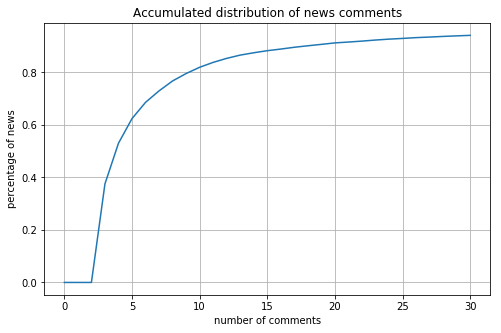

In [14]:
# df_all = pd.read_pickle('./data/5h_basic.p')
news_comments = list(train_df['num_tw'])

t = np.linspace(0, 30, 31)
d = []
for i in t:
    d.append(sum([1 for num in news_comments if num < i])/len(news_comments))

plt.figure(figsize = (8,5))
# plt.subplot(121)
plt.plot(t,d)
plt.xlabel('number of comments')
plt.ylabel('percentage of news')
plt.title('Accumulated distribution of news comments')
plt.grid()

foo = plt.gcf()
plt.savefig('distribution.pdf', format='pdf', dpi=1000)

# plt.subplot(122)
# plt.hist([i for i in news_comments if i<20])
# plt.xlabel('number of comments')
# plt.ylabel('number of news')
# plt.title('Distribution of number of comments')
# plt.show()

In [ ]:
df.drop(index=[0, 1])
'https://bitcoinexchangeguide.com/dubais-palmex-exchange-granted-regulatory-sandbox-license-by-bahrain/'

In [79]:
l = p['https://bitcoinexchangeguide.com/dubais-palmex-exchange-granted-regulatory-sandbox-license-by-bahrain/']['tweets']

In [93]:
k= 'https://bitcoinexchangeguide.com/dubais-palmex-exchange-granted-regulatory-sandbox-license-by-bahrain/'
k=url
tweet_list = p[k]['tweets']
news_time = p[k]['tweets'][0]['timestamp_ms']
for i in tweet_list:
    time_diff = (i['timestamp_ms'] - news_time)/60/60/1000
    print(time_diff)
    i['time_diff'] = time_diff
    i['time_zone'] = i['time_diff'] / INTERVAL // 1 * INTERVAL # according to interval

0.0
0.11202972222222224
0.12988555555555556
0.1356747222222222
0.39382249999999996
0.8428491666666666
1.102891388888889
1.2166683333333335
1.316885277777778
1.4381933333333334
5.061959166666666
5.076335
5.076647777777778
5.12862111111111
5.130666111111112
5.197448888888889
5.214272222222222
5.229321111111111
5.258962222222222
5.266746944444444
5.342744166666668
6.283533333333334
6.381194722222222
8.15395
12.326913333333334
12.390783333333333
12.435591388888888
12.437639722222222
12.438308055555556
12.439046111111113
12.439605000000002
12.44016361111111
12.596705833333333
12.762293333333334
12.969072222222223
14.17561277777778
14.243775
14.550345277777778
14.726890555555556
14.805215
14.884245555555555
14.939922777777777
14.958073333333333
15.038810833333333
15.144365555555556
15.166865555555557
15.211301944444445
15.475104166666666
15.595737777777778
15.841772777777779
15.88009361111111
15.94732138888889
16.05074388888889
16.39554833333333
16.554369166666667
16.583939722222222
16.72595

In [92]:
url='https://www.theguardian.com/technology/2018/nov/05/energy-cost-of-mining-bitcoin-more-than-twice-that-of-copper-or-gold'

In [ ]:
df_ts=pd.read_pickle('./data/time_series.p')

In [ ]:
a = list(df_all[df_all['url']==url]['time_list'])
b = list(df_all[df_all['url']==url]['tw_list'])

In [ ]:
a

In [ ]:
b[0][4:8]

In [ ]:
for x,y in zip(a[0][4:8],b[0][4:8]):
    print(x)
    print(y)